# House Pricing Competition - Kaggle

Jose Valero

## Importing and Gathering Data

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [4]:
#Read the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Target Variable

We will be predicting the prices for the houses in the 'test.csv' data. Therefore, our target variable will be 'SalePrice'.

Let's first have a look at the distribution of the target variable.

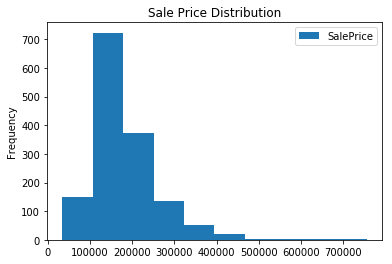

In [5]:
train.plot(kind = 'hist', y = 'SalePrice', title = 'Sale Price Distribution');# Plot a Histogram

We can see that the Sale Price distribution is skewed to the right due to some outliers. These outliers might end up affecting the model, so to help our linear regression model, we will log the target variable in order to get something closer to a Normal Distribution.

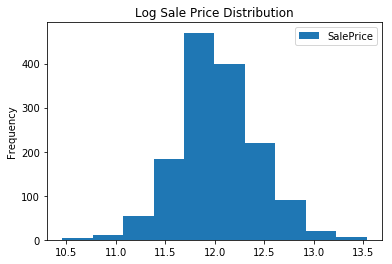

In [6]:
target= train.copy() #Copy the train
target['SalePrice'] = np.log(target['SalePrice']) # Transform Log the SalePrice variable
target.plot(kind = 'hist', y = 'SalePrice', title = 'Log Sale Price Distribution'); #Creates Histogram

The log transformation has worked and the ```log(SalePrice)``` follows now a normal distribution, which will help the linear regression model we will build afterwards. 

After building the model and predicting the house prices, we will need to transform this prices back to normal using the ```exp()``` function.

## Wrangling Data

First of all, we will clean the data, getting rid of some outliers and filling null values.

We will also select the Categorical variables we are interested in, and transform them into dummy variables for our linear regression to work. 

When dropping variable or converting categorical data into dummy variables in our Train dataset, we need to the same to our test dataset. The reason is that the model built with the Train dataset has to fit the test dataset, so it needs to have the same variables and format than the train dataset.

### Numerical Variables

#### Outliers

We will first look at the numerical variables, selecting just the numerical values from our train dataset.


In [7]:
data = train.select_dtypes(include=[np.number]) # It selects only the numerical variables
data.columns # show all the columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Once we have all numerical varables, let's plot them vs Sale price. 

This will allow us to spot outliers which we will remove later on.

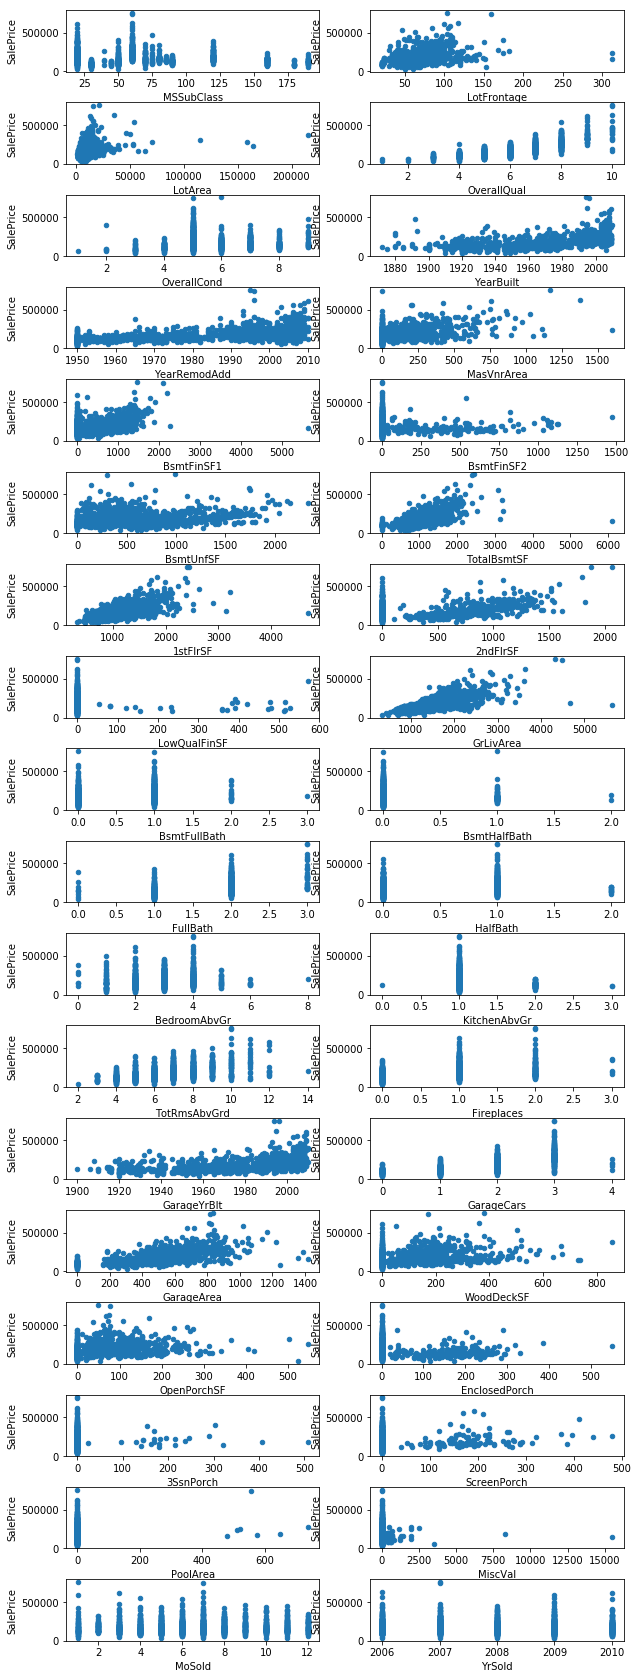

In [8]:
a =data.columns[1:37] #All numerical variables names. 'Id' or 'Sale Price' NOT included

fig , axes = plt.subplots(nrows= len(a)//2,ncols=2, figsize = (10,30))
fig.subplots_adjust(hspace = 0.5)

for i, variable in enumerate(a):
    data.plot(kind='scatter', x = variable, y = 'SalePrice', ax = axes[i // 2][i % 2])

We can see how some numerical variables do contain outliers and we will need to remove them in order to get a more accurate regression model.

The variabes we will ammend are:

- 'LotArea'
- 'LotFrontage'
- 'MasVnrArea'
- 'YearBuilt'
- 'GrLivArea'
- 'GarageArea'
- 'WoodDeckSF'
- 'OpenPorchSF'
- 'EnclosedPorch'
- 'MiscVal'

In [9]:
train= train[train['LotArea'] < 50000]
train= train[train['LotFrontage'] < 150]
train= train[train['MasVnrArea'] < 750]
train= train[train['YearBuilt'] > 1900]
train= train[train['BsmtUnfSF'] < 2500]
train= train[train['GrLivArea'] < 3500]
train= train[train['GarageArea'] < 1100]
train= train[train['WoodDeckSF'] < 1100]
train= train[train['OpenPorchSF'] < 350]
train= train[train['EnclosedPorch'] < 300]
train= train[train['MiscVal'] < 2500]

#### Duplicated Variables

There are some variables that relate to each other, and therefore we can drop them or combine them.

The first case is the four different variables for Basement square feet. I will keep just the ```Total Basement Square feet```, and drop the Basement square feet for the each different type of basement.

In [10]:
#removing basement variable not used
train.drop(['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF'], axis =1, inplace=True)
test.drop(['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF'], axis =1, inplace=True)

There are also two variable for square floor feet, one for each floor of the house, so we will aggregate both to get a total square foot of the house, and finally drop the first two.

In [11]:
train['total_floor_sqfeet'] = train['1stFlrSF'] + train['2ndFlrSF']
print(train[['1stFlrSF','2ndFlrSF','total_floor_sqfeet']].head())
train.drop(['1stFlrSF','2ndFlrSF'], axis =1, inplace=True)

test['total_floor_sqfeet'] = test['1stFlrSF'] + test['2ndFlrSF']
test.drop(['1stFlrSF','2ndFlrSF'], axis =1, inplace=True)

   1stFlrSF  2ndFlrSF  total_floor_sqfeet
0       856       854                1710
1      1262         0                1262
2       920       866                1786
3       961       756                1717
4      1145      1053                2198


We will also get rid of the low quality square feet as it seems redundant.

In [12]:
#Dropping low quality square metre
train.drop(['LowQualFinSF'], axis =1, inplace=True)
test.drop(['LowQualFinSF'], axis =1, inplace=True)

### Non-Categorical Values

Let's now focus on the categorical data.

We are now going to check all variable and afterwards choose those we are going to use in our model.

In order to check the variables, we will plot the mean Sale Price for each of the factors within the variables and see whether there are factors with significant mean differences, which need to should be added to the model.

After selecting the variables, we will create the dummy version of them, so they can be used to build the linear regression model.

Let's first extract all Categorical variables from the train dataset.

In [13]:
categorical_data = train.select_dtypes(exclude=[np.number]) # Extract all variables excluding numerical variables.
categorical_data.columns #Show columns names

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

Let's now plot the Mean Sales price by each categorical value. 

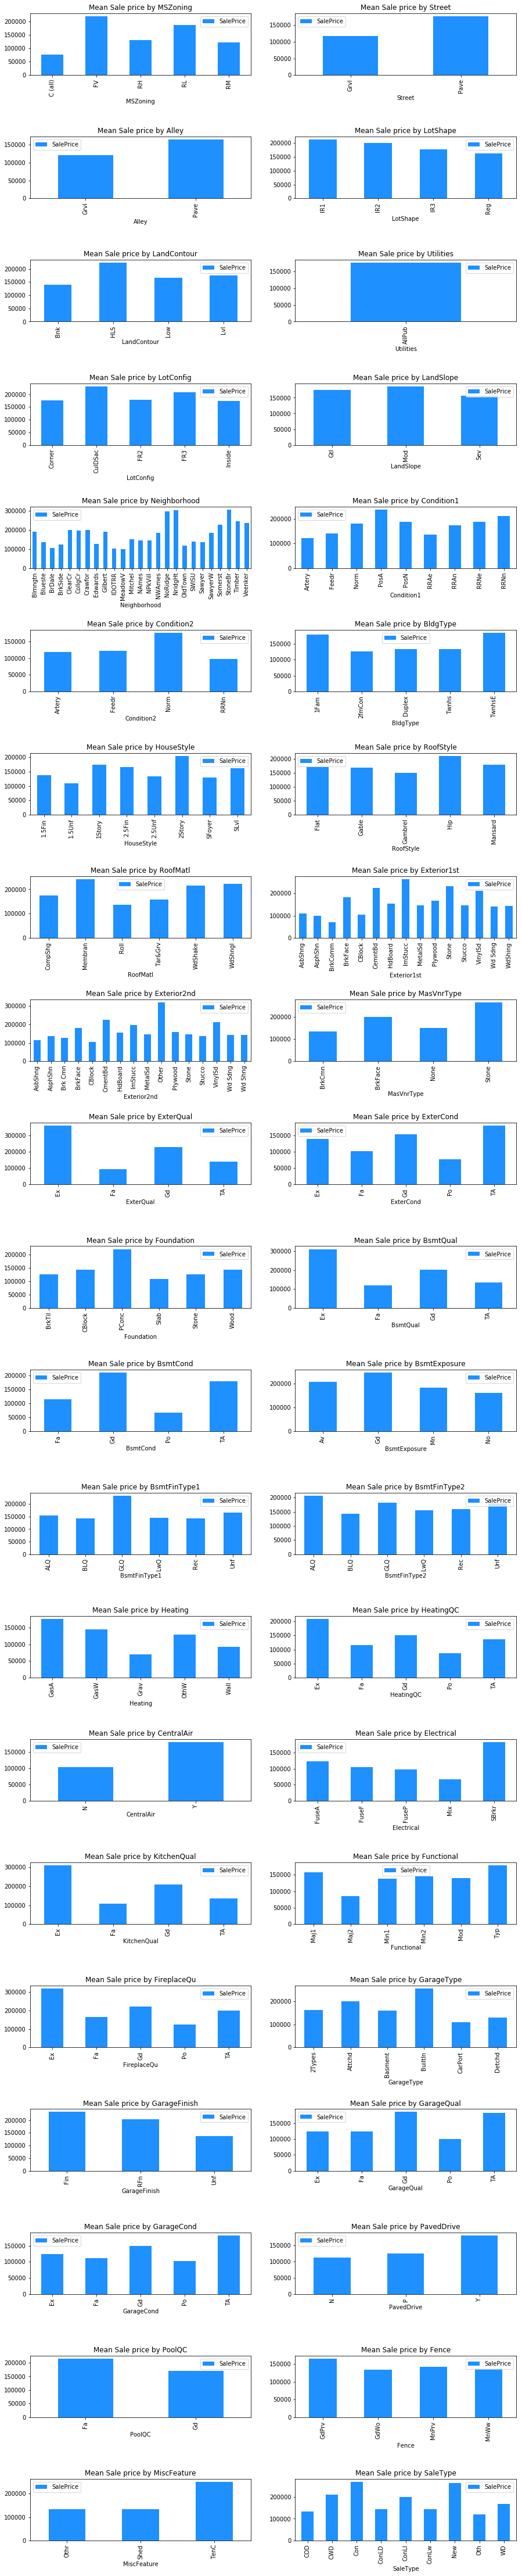

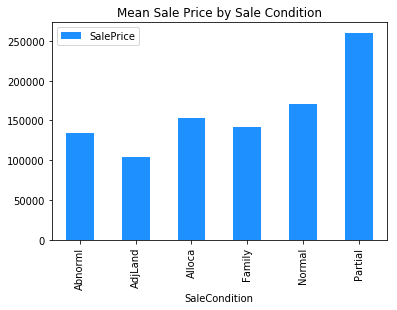

In [14]:
fig, axes = plt.subplots(nrows= 21, ncols=2, figsize=(15,80)) # Sets the subplots grid and the grid size.

fig.subplots_adjust(hspace = 1) # Sets the space between plots. This case it sets the space between rows 'hspace'

# Loop that creates all plot and place them in their correct place within the grid
for i, variable in enumerate(categorical_data.columns[:42]):
    train.pivot_table(values = 'SalePrice', index = variable).plot(kind = 'bar', ax = axes[i//2][i%2],
                                                                    title = 'Mean Sale price by {}'.format(variable),
                                                                    color = 'dodgerblue');

# Creates the last plot, as the number of plots were odd and the for loop was set for even number of plots
train.pivot_table(values = 'SalePrice', index = 'SaleCondition').plot(kind = 'bar',
                                                                      title = 'Mean Sale Price by Sale Condition', 
                                                                      color = 'dodgerblue');

As for the categorical data, I will use in my model:

- Zoning classification (MSZoning)
- Street access to property (Street): Whether the road is Paved or not (graved)
- Sale Condition: Whether is Partial or not.

#### Area of the propterty



Let's create dummy variable for the type of areas 'MSZoning'.

In [15]:
train= pd.concat([train,pd.get_dummies(train['MSZoning'])], axis =1) # Creates Dummies for the train dataset
test= pd.concat([test,pd.get_dummies(test['MSZoning'])], axis =1) # Creates Dummies for the test dataset

Let's encode the variable whether is in a Residential area or not

#### Street Access

Let's encode the Street variable differenciating whether the Street access is Pavemented or not.

In [16]:
def encoding(x): return 1 if x == 'Pave' else 0
train['ecoding_Street'] = train['Street'].apply(encoding) # Encode the variable in the train dataset
test['ecoding_Street'] = test['Street'].apply(encoding) # Encode the variable in the test dataset

#### Sale Condition

Due to the houses with the sale condition 'Partial' has a significantly higher mean value, we will encode the SaleCondition variable between those houses with the condition 'Partial' and the rest.

In [17]:
def encoding(x): return 1 if x == 'Partial' else 0

train['econding_SalesCondition'] = train['SaleCondition'].apply(encoding) # Encode the variable in the train dataset
test['econding_SalesCondition'] = test['SaleCondition'].apply(encoding) # Encode the variable in the test dataset

### Numerical Null values

After looking at numerical variables removing their outliers, and also choosing and converting into numerical the categorical variables, let's tackle now the null values from Numerical variables.

In order to solve the issue, I have decided to interpolate the null values replacing missing values with the mean for their entire series.

In [18]:
data = train.select_dtypes(include=[np.number]) # Select all numerical variables (Now it includes all Dummies Variables)

data = data.interpolate(method = 'linear') # Replace null values with the 'mean' of each series.

print('There are {} null values in the dataset'.format(data.any().isna().sum()))

There are 0 null values in the dataset


## Building the Model

Let's start building the model. As we mentioned in the beginning, we will first do a logarithm transform to SalesPrice, so its distribution becomes Normal.

After predicting the House prices in the test dataset with the model, we need to transform back to normal the predictions, so it represents real price values and not log values.

In [19]:
train['SalePrice'] = np.log(train['SalePrice'])

We are now ready to separate the variables for modelling.

Id and SalePrice will be removed from the as one is just the index and the other is the target variable.

In [20]:
y = np.log(data['SalePrice']) # Assign the target variable from the train dataset

X = data.drop(['Id','SalePrice'], axis =1) # Assign the variables we will be use to predict 'y' from the train dataset

#### Partitioning the data
Now, in order to test our model, we can split the train dataset into two subsets:

- Train (75%)
- Test (25%)

In [21]:
#Splits the train dataset (X, y) into a train and test version. This will help us score our model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

#### Modelling

Let's create our linear regression model using the training data just splitted.

In [22]:
lr = LinearRegression() #Assign the funciton to an object
model = lr.fit(X_train, y_train) # Builds the regression model

## Evaluation

Now we will evaluate how accurate our model is against the test split from the training dataset.

We will use:

- **R- square** which measures how close are the values to the fitted linear regression model we build. 

- **Root mean square error (RMSE)** which measure the distance between the predicted values and the actual values.

#### R-Squared

In [23]:
model.score(X_test, y_test) #R-square

0.9065343278225617

85% of the variance in the Sale Price of the house is explained by the model.

#### Root Mean Square Error (RMSE)

In [24]:
predictions = model.predict(X_test) # Predict the prices with the model previously built
rmse = mean_squared_error(y_test, predictions) # Return the root mean square error of the predictions

print('The RMSE is {:.2}. Have in mind that this is a log value.'.format(rmse))

The RMSE is 0.014. Have in mind that this is a log value.


#### Plotting results

Let's plot the difference between the predictions and the real values. 

Due to the two results we got:

- R-Square = 89%
- RMSE = 0.017

we expect the difference to follow close to a straight line.

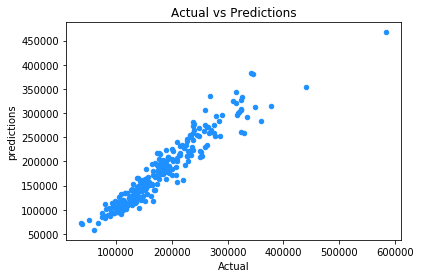

In [25]:
# Transform the 'log' values into normal Sale price.
mean_error_plot = pd.DataFrame({'predictions': np.exp(predictions), 'Actual': np.exp(y_test)})

# Creates the scatter plot comparing predictions to actual.
mean_error_plot.plot(kind='scatter', x = 'Actual', y = 'predictions',
                     color = 'dodgerblue', title='Actual vs Predictions');

## Submission

We will now use this model to predict the value for the original test dataset. We will then save it in a ```csv``` file and submit it to Kaggle.

We did make the same change to test when wrangling the Train dataset, so we do not need to do more than select the same variable than the model we built for the Train dataset and fill the NAs

In [26]:
# Selects just the numeric variables (including dummies)
# Fill the null values with the mean value of each serie
features = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis =1).interpolate()

In [27]:
submission = pd.DataFrame() #Creates an empty Dataframe
submission['Id'] = test['Id'] # Creates a new variable Id and add to it the test ID values

In [28]:
predictions = model.predict(features) # Predicts the Sales Value for the observations in the test dataset

final_predictions = np.exp(predictions) #Transform the predicted values from log value to normal. 

submission['SalePrice'] = final_predictions # Add to the dataframe the predictions

In [29]:
submission.to_csv('house_pricing.csv',index=False) # Writes a csv file without index.